###### Кейс №1 - Приложение знакомств
_Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые <br>
отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.<br>
В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой <br>
они группы АБ-теста и случился ли у них мэтч.<br>
Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех <br>
пользователей.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import plotly.express as px
import scipy.stats as stats
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal 

In [4]:
data = pd.read_csv('dating_data.csv')
data.head(3)

user_id_1  user_id_2  group  is_match
0         79         91      1         1
1        716        353      1         1
2        423        677      0         0

In [ ]:
#Проверим данные на дубликаты, пропуски и посмотрим типы данных
#data[data.duplicated()]
#data.isna().sum()
#data.dtypes
#С данными все отлично, можно приступать к анализу

_Визуализирем количество метчей по группам

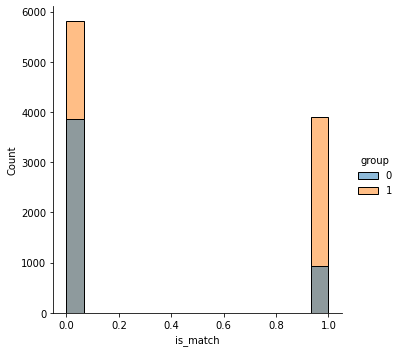

In [19]:
sns.displot(data= data, x = 'is_match', hue = 'group')

_Проверим взаимосвязь между группой и метчами <br>
Для проверки этой гипотезы я использую ХИ-КВАДРАТ, поскольку переменные: ОБЕ КАТЕГОРИАЛЬНЫЕ.<br>
𝐻0 : взаимосвязи между переменными нет <br>
𝐻1 : взаимосвязь есть

In [46]:
tab = pd.crosstab(data.is_match, data.group)
tab

group        0     1
is_match            
0         3858  5813
1          934  3909

In [66]:
chi2_contingency(tab)

(618.6889141576197,
 1.441829916366341e-136,
 1,
 array([[3193.01584677, 6477.98415323],
        [1598.98415323, 3244.01584677]]))

_Нулевая гипотеза ОТКЛОНЯЕТСЯ, поскольку p-value < 0. 05. Значит, ВЗАИМОСВЯЗЬ ЕСТЬ.

_Сгруппируем данные по юзерам и посмотрим сколько на каждого приходится лайков и мэтчей. <br>
Посчитаем конверсию лайков в мэтчи в процентах - MTR (match-through rate)

In [65]:
#Чтобы съагрегировать по юзерам, расплавим колонки 'user_id_1', 'user_id_2'

data_melted = data.melt(id_vars=['group', 'is_match'], value_vars=['user_id_1', 'user_id_2'], var_name='user_id')
data_melted = data_melted.reindex(['value','group', 'is_match', 'user_id'], axis= 1).rename(columns = {'value': 'user'})
data_melted.head(3)

user  group  is_match    user_id
0    79      1         1  user_id_1
1   716      1         1  user_id_1
2   423      0         0  user_id_1

In [66]:
df = data_melted.groupby(['group', 'user'], as_index = False).agg({'user_id': 'count', 'is_match': 'sum'}) \
    .rename(columns = {'user_id': 'count_likes', 'is_match': 'count_matches'})
df['MTR'] = (df.count_matches / df.count_likes * 100).round(2)
df.head(3)

group  user  count_likes  count_matches    MTR
0      0     4           17              3  17.65
1      0    10           20              6  30.00
2      0    12           20              2  10.00

_Проверим взаимовзязь между группой и MTR <br> 


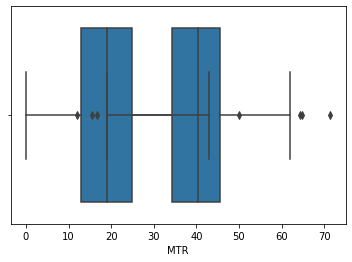

In [68]:
sns.boxplot(data = df[df.group == 0], x = 'MTR')
#plt.show()
sns.boxplot(data = df[df.group == 1], x = 'MTR')

In [ ]:
#Из boxplot-ов видны стат значимые различия между группами. Подтвердим тестом.

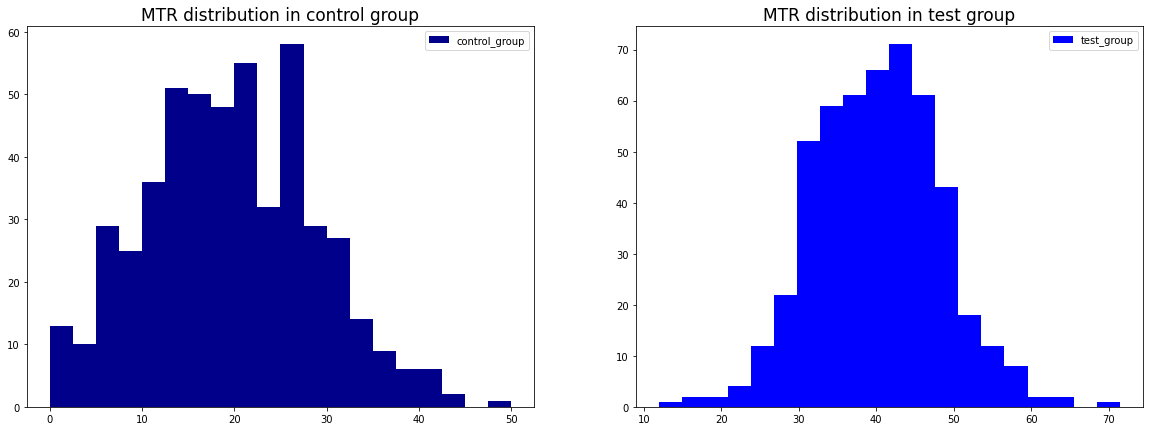

In [69]:
#Визуализация распределения MTR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax2.set_title('MTR distribution in test group', fontsize = 17)
ax2.hist(df[df.group ==1].MTR, bins=20, label='test_group', color='blue')
ax2.legend()

ax1.hist(df[df.group ==0].MTR, bins=20, label='control_group', color='darkblue')
ax1.legend()
ax1.set_title('MTR distribution in control group', fontsize = 17)
plt.show()


In [70]:
pg.normality(data = df, dv = 'MTR', group = 'group', method = 'normaltest')

W      pval  normal
0  3.140401  0.208003    True
1  4.214365  0.121580    True

_Для проверки этой гипотезы я использую t-test <br>
𝐻0 : взаимосвязи между переменными нет<br> 
𝐻1 : взаимосвязь есть

In [71]:
control_df = df[df.group == 0]
test_df = df[df.group == 1]

In [72]:
stats.ttest_ind(control_df.MTR, test_df.MTR)

Ttest_indResult(statistic=-38.234390387113116, pvalue=1.0376925074337772e-197)

_Нулевая гипотеза ОТКЛОНЯЕТСЯ, поскольку p-value < 0. 05. Значит, ВЗАИМОСВЯЗЬ ЕСТЬ.<br>
В нашем эксперименте было получено стат значимое различие между средними конверсии лайков в мэтчи между группами.

_Возьмем третью метрику: количество лайков на пользователя.<br>
Теперь посмотрим увеличилоь ли оно в тестовой группе значимо по сравнению с контрольной.<br>
Нулевая гипотеза: 𝐻0 : взаимосвязи между переменными нет.<br>
Альтернативная гипотеза: 𝐻1: взаимосвязь есть.

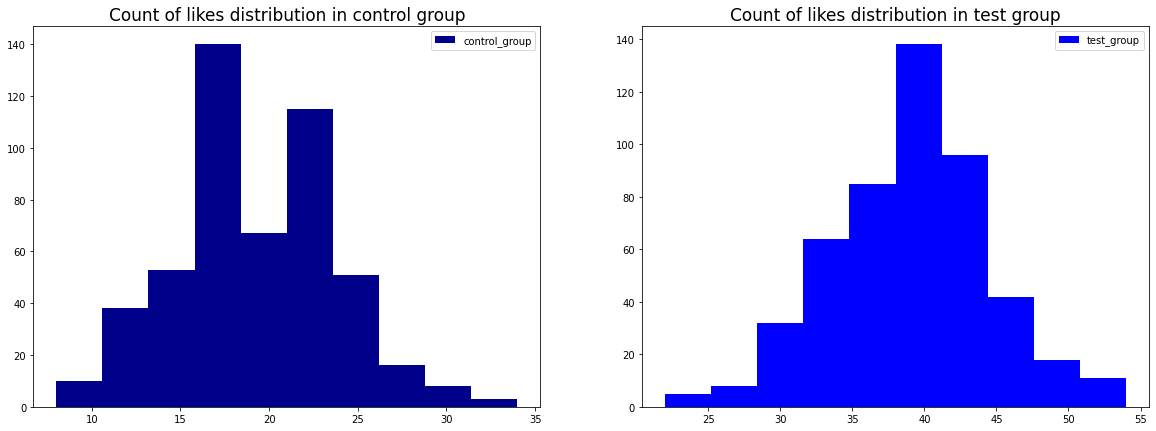

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax2.set_title('Count of likes distribution in test group', fontsize = 17)
ax2.hist(df[df.group ==1].count_likes, label='test_group', color='blue')
ax2.legend()

ax1.hist(df[df.group ==0].count_likes, label='control_group', color='darkblue')
ax1.legend()
ax1.set_title('Count of likes distribution in control group', fontsize = 17)
plt.show()

_Распределения кажутся нормальными, проверим тестом




In [77]:
pg.normality(data = df, dv = 'count_likes', group = 'group', method = 'normaltest')

W      pval  normal
0  5.214400  0.073741    True
1  0.319658  0.852289    True

_Так как распределения нормальные можем использовать тест Стьюдента

In [79]:
stats.ttest_ind(control_df.count_likes, test_df.count_likes)

Ttest_indResult(statistic=-62.837086115525075, pvalue=0.0)

_pvalue значительно < 0.05, следовательно отклоняем нулевую гипотезу и можно сделать вывод, что различия между группами стат значимы

###### Вывод: <br>
        мы выявили взаимосвязь между группами и метчами,
        конверсией метчей из лайков и количеством лайков на пользователя. 
        Показатели в тестовой группе увеличелись стат значимо, 
        поэтому делаем вывод, что новую систему поиска анкет рекомендуется включить на всех пользователей.